In [274]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print('imported')

imported


In [273]:
#read in raw data
lego_raw_df = pd.read_csv('legoData.csv',index_col = 0)

# info() to see what has the most nulls
lego_raw_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19145 entries, 0 to 19144
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Set_number     19145 non-null  object 
 1   Name           19144 non-null  object 
 2   Set_type       19144 non-null  object 
 3   Theme          19144 non-null  object 
 4   Theme_group    19143 non-null  object 
 5   Subtheme       15561 non-null  object 
 6   Year_released  19144 non-null  float64
 7   Pieces         15297 non-null  float64
 8   Minifigs       8456 non-null   float64
 9   Price          19145 non-null  float64
 10  Age_range      7032 non-null   object 
dtypes: float64(4), object(7)
memory usage: 1.8+ MB


In [250]:
# describe() to see some of the basic stats
lego_raw_df.describe()


,Year_released,Pieces,Minifigs,Price
count,19144.000000,15297.000000,8456.000000,19145.000000
mean,2006.394693,224.932993,2.672304,18.556218
std,14.598790,469.083890,2.898825,39.792932
min,1949.000000,0.000000,1.000000,0.000000
25%,2000.000000,22.000000,1.000000,0.000000
50%,2011.000000,69.000000,2.000000,4.990000
75%,2017.000000,241.000000,3.000000,19.990000
max,2023.000000,11695.000000,80.000000,849.990000


In [251]:
#First to take a look at the set that is missing a name:
lego_raw_df.loc[lego_raw_df.Name.isna()]


,Set_number,Name,Set_type,Theme,Theme_group,Subtheme,Year_released,Pieces,Minifigs,Price,Age_range
5830,KC028-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [254]:
#This page was either moved or the scraper picked up an incorrect ID so we'll remove it for now
lego_mod_df = lego_raw_df.dropna(subset=['Name'])

In [264]:
#next to check on the 80 minifigs, that seems like a lot
lego_raw_df.loc[lego_raw_df.Minifigs==80]

,Set_number,Name,Set_type,Theme,Theme_group,Subtheme,Year_released,Pieces,Minifigs,Price,Age_range
1599,3695-1,Figure collection,Normal,FABULAND,Junior,NaN,1982.0,NaN,80.0,0.0,NaN


In [266]:
#This set seems like it was a promotional piece, and not a lot is known about it, including price.
#I think the thing to do here would be remove all entries that have no Price data, or have a 0 price
#as they could be promotional, or they might just be more mystery sets that do not have a lot of info surrounding them

lego_mod_df = lego_raw_df.dropna(subset=['Price'])
lego_mod_df = lego_mod_df[lego_mod_df.Price !=0.00]

#Then redescribe to see how that changes things
lego_mod_df.describe()

,Year_released,Pieces,Minifigs,Price
count,11384.000000,9413.000000,6164.000000,11384.000000
mean,2010.200545,289.558483,2.866807,31.206852
std,10.571208,546.873550,2.682497,47.626474
min,1961.000000,0.000000,1.000000,0.400000
25%,2004.000000,34.000000,1.000000,6.990000
50%,2013.000000,109.000000,2.000000,15.000000
75%,2018.000000,333.000000,4.000000,37.500000
max,2023.000000,11695.000000,33.000000,849.990000


In [270]:
#33 still seems like a lot of minifigs for one set, but we'll look at the histograms in a moment and see what they tell
#while 11695 pieces and 849.99 might seem like large values for lego sets. I happen to know which sets these are referring to
#and that they are legitimate sets

#separate into numeric and categorical features:
lego_num = lego_mod_df[['Year_released', 'Pieces', 'Minifigs', 'Price']]
lego_cat = lego_mod_df[['Set_number', 'Name', 'Set_type', 'Theme', 'Theme_group', 'Subtheme', 'Age_range']]

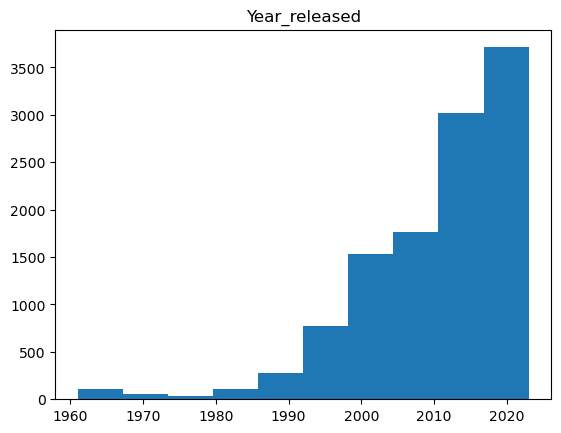

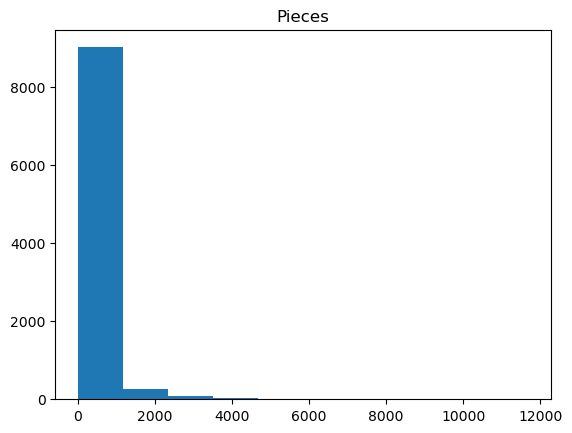

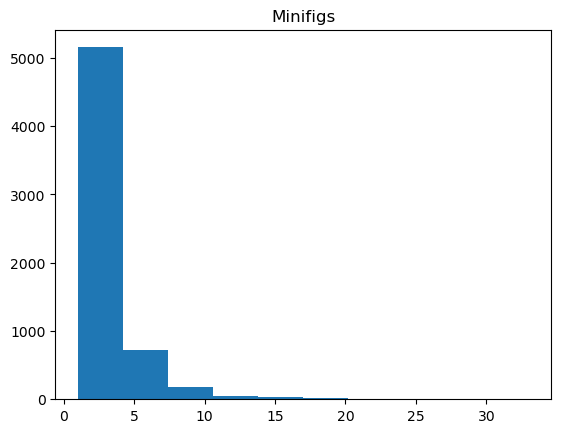

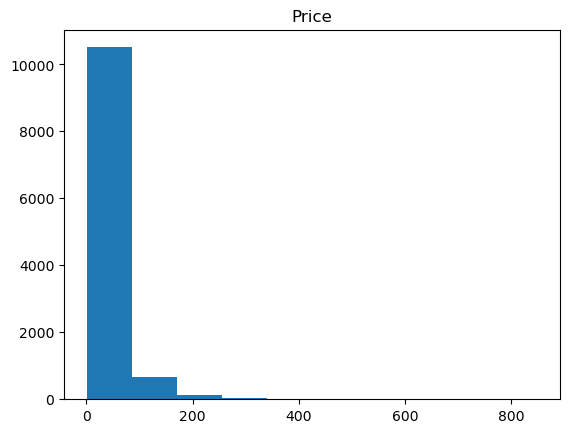

In [271]:
#histograms for all numerical features

for i in lego_num.columns:
    plt.hist(lego_num[i])
    plt.title(i)
    plt.show()
    

               Year_released    Pieces  Minifigs     Price
Year_released       1.000000  0.169869  0.022959  0.149408
Pieces              0.169869  1.000000  0.552333  0.856167
Minifigs            0.022959  0.552333  1.000000  0.541144
Price               0.149408  0.856167  0.541144  1.000000


<AxesSubplot: >

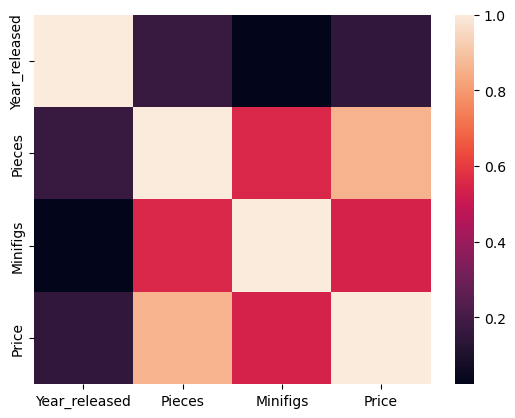

In [277]:
#Before moving on a couple of things to note, all of the data is quite heavily skewed. They high piece count and high 
#price sets are both outliers. Perhaps normalize? Then Scale

#First some correlations
print(lego_num.corr())
sns.heatmap(lego_num.corr())


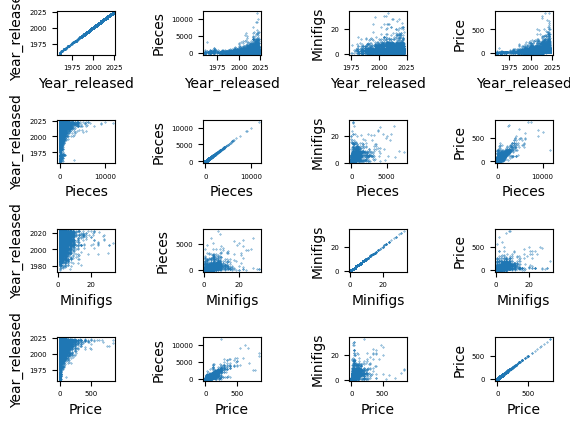

In [295]:
#Observations:
#Pieces and price are very heavily correlated
#Minifigs and price are also quite correlated
#No correlation between year released and number of minifigs
#slightly higher for year released nad pieces and price.
#If price is what we want to end up predicting for new sets, then pieces and minifigs are definitely worth exploring

#Maybe scatter plots might tell us some more. 
#If we're looking at predictors of price, we'll put price on Y and the other variables on X
figure, axis = plt.subplots(4,4)
for c,i in enumerate(lego_num.columns):
    for r,k in enumerate(lego_num.columns):
        axis[c, r].scatter(lego_num[i], lego_num[k], s=.1)
        axis[c, r].set(xlabel=i,ylabel=k)
        axis[c, r].tick_params(labelsize = 5)
plt.subplots_adjust(wspace=1.5,hspace=1.5)
plt.show()
                
#Note: This will give us price vs price, but this is just a quick example

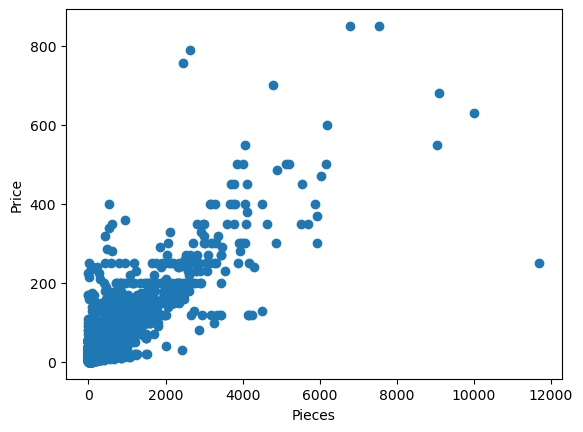

In [298]:
#these scatter plots show that the maximum price and pieces have both increased over the years
#we'll also take a more in depth look at pieces vs price, as these two are very correlated.
#So if we were predicting price this would bea key variable

plt.scatter(lego_num.Pieces, lego_num.Price)
plt.xlabel("Pieces")
plt.ylabel("Price")
plt.show()

In [303]:
#What this shows us is that 11000 piece is priced very low. This is because all of the pieces are small
#It is also just a very well priced set. Maybe our categorical data will capture why. 
#This entry might be worth keepeing an eye on, the ID is 31203-1

#Next the categorical data.
#Lets look at the amount of unique values in each feature
for i in lego_cat.columns:
    print("Unique "+ str(i)+ "s: "+ str(len(lego_cat[i].unique())))
    


Unique Set_numbers: 11384
Unique Names: 10268
Unique Set_types: 7
Unique Themes: 149
Unique Theme_groups: 16
Unique Subthemes: 785
Unique Age_ranges: 56


In [ ]:
#also remove sets that have less than 10 pieces, as these are likely individual minifigure packs, which is 
# different to the full lego sets we will be looking at, and will obscure fitting price, as well as minifigs to the full sets
lego_mod_df = lego_mod_df[lego_mod_df.Pieces >10]



In [239]:

#I am going to remove the pre 90s data as the product and company size was much different back then, as such the data
#would be minimally helpful in recognizing current trens, but would increase a lot of complexity in cleaning the dataset
lego_mod_df = lego_mod_df[lego_mod_df.Year_released  >=2000]


#I'm going to assume that if there was no data on minifigs on the website that means there were no minifigs
lego_mod_df['Minifigs'] = lego_mod_df['Minifigs'].fillna(0)


#remove rows containing unwated themes, this list is obtained by exploring the code in the next cell and researching
#the website to see what themes are unsuitable
unwanted_themes = ['BOOKS','DUPLO', 'PRIMO', 'SCALA', 'BABY', 'BULK BRICKS', 'BIONICLE', 'CLIKITS', 'QUATRO', 
                   'SERVICE', 'PACKS']
lego_mod_df = lego_mod_df[~lego_mod_df.Theme.isin(unwanted_themes)]



lego_mod_df.columns = lego_mod_df.columns.astype(str)
#we are going to create a column from the original Age range column called "MinimumAge"

#lego_ageRange_df = lego_mod_df.dropna(subset="Age_range")
lego_mod_df['Minimum_age'] = lego_ageRange_df['Age_range'].str.replace('+', '', regex=True).str.split(' -',).str[0].astype(int)


#lego_ageRange_df['Age_range'] = lego_ageRange_df['Age_range'].str.split(' -',).str[0]
#lego_ageRange_df['Age_range'] = lego_ageRange_df['Age_range'].astype(int)



lego_mod_df.head


['Unnamed: 0' 'Set_number' 'Name' 'Set_type' 'Theme' 'Theme_group'
 'Subtheme' 'Year_released' 'Pieces' 'Minifigs' 'Price' 'Age_range']


<bound method NDFrame.head of       Set_number                             Name  Set_type            Theme  \
4606      1263-1                     Easter Bunny    Normal         SEASONAL   
4608      1272-1                       Blue Racer    Normal             TOWN   
4630      1349-1  Steven Spielberg Moviemaker Set    Normal          STUDIOS   
4652      2250-1                  Advent Calendar    Normal            BASIC   
4680      2904-1                        Motorbike    Normal  ACTION WHEELERS   
...          ...                              ...       ...              ...   
19125   910002-1           Studgate Train Station  Extended        BRICKLINK   
19126   910004-1                    Winter Chalet  Extended        BRICKLINK   
19127   910008-1        Modular Construction Site  Extended        BRICKLINK   
19128   910011-1                     1950's Diner  Extended        BRICKLINK   
19129   910027-1        Mountain View Observatory  Extended        BRICKLINK   

         

In [150]:
#going to get the unique values of theme to see if any stand out as not applicable, then process these in 
#the line above once obtained
print(lego_mod_df['Theme'].unique())

['TOWN' 'ASSORTED' 'SERVICE PACKS' 'MODEL TEAM' 'CASTLE' 'SPACE' 'TECHNIC'
 'BASIC' 'BOATS' 'TRAINS' 'PIRATES' 'DACTA' 'BELVILLE' 'AQUAZONE'
 'FREESTYLE' 'TIME CRUISERS' 'WESTERN' 'CLASSIC' 'ADVENTURERS' 'ZNAP'
 'RACERS' 'MINDSTORMS' 'SEASONAL' 'ROCK RAIDERS' 'STAR WARS' 'EDUCATION'
 'STUDIOS' 'ACTION WHEELERS' 'SPORTS' 'ADVANCED MODELS' 'MICKEY MOUSE'
 'CREATOR' 'JACK STONE' 'HARRY POTTER' 'DINOSAURS' 'ALPHA TEAM' 'EXPLORE'
 'SPYBOTICS' 'ISLAND XTREME STUNTS' 'GALIDOR' 'WORLD CITY' '4 JUNIORS'
 'SPIDER-MAN' 'DISCOVERY' 'HOBBY SET' 'MAKE AND CREATE' 'FACTORY'
 'VIKINGS' 'CITY' 'DINO ATTACK' 'SPONGEBOB SQUAREPANTS'
 'AVATAR THE LAST AIRBENDER' 'EXO-FORCE' 'BATMAN' 'AQUA RAIDERS'
 'BRICKS AND MORE' 'INDIANA JONES' 'AGENTS' 'ARCHITECTURE' 'MISCELLANEOUS'
 'GAMES' 'POWER MINERS' 'HERO FACTORY' 'PRINCE OF PERSIA' 'TOY STORY'
 'ATLANTIS' 'BEN 10: ALIEN FORCE' 'WORLD RACERS' 'UNIVERSE' 'SERIOUS PLAY'
 'PROMOTIONAL' 'NINJAGO' 'PIRATES OF THE CARIBBEAN' "PHARAOH'S QUEST"
 'CARS' 'MASTER BUILDER

In [160]:
#we are going to use this to explore sets in various themes, to find out whether they apply to lego sets.
#eg. Duplo might seem like it is lego, however the blocks are much bigger and aimed at much younger kids
#this will allow us to get a handle on whether certain themes and subthemes should be included

#'BOOKS','DUPLO', PRIMO, SCALA, BABY,  BULK BRICKS, BIONICLE CLIKITS QUATRO are removed as they are not lego sets
#SERVICE PACKS is removed as these are replacement parts and not sets

#Consider removing COLLECTABLE MINIFIGURES as these are just minifigure sets, however the > 10  piece count 
#means that there is some lego involved


lego_mod_df.loc[lego_mod_df['Theme'] == 'COLLECTABLE MINIFIGURES']

,Unnamed: 0,Set_number,Name,Set_type,Theme,Theme_group,Subtheme,Year_released,Pieces,Minifigs,Price,Age_range,Minimum_age
10182,10182,8831-4,Bride,Normal,COLLECTABLE MINIFIGURES,Miscellaneous,SERIES 7,2012.0,11.0,1.0,2.99,5+,5.0
10476,10476,850449-1,Minifigure Accessory Pack,Extended,COLLECTABLE MINIFIGURES,Miscellaneous,COMBI-PACK,2012.0,63.0,3.0,14.99,6+,6.0
10483,10483,850458-1,VIP Top 5 Boxed Minifigures,Extended,COLLECTABLE MINIFIGURES,Miscellaneous,COMBI-PACK,2012.0,37.0,5.0,12.99,5+,5.0
10484,10484,850486-1,Rock Band Minifigure Accessory Set,Extended,COLLECTABLE MINIFIGURES,Miscellaneous,COMBI-PACK,2012.0,62.0,3.0,14.99,6+,6.0
10485,10485,850487-1,Halloween Accessory Set,Extended,COLLECTABLE MINIFIGURES,Miscellaneous,COMBI-PACK,2012.0,58.0,3.0,14.99,6+,6.0
13271,13271,71013-1,Ice Queen,Normal,COLLECTABLE MINIFIGURES,Miscellaneous,SERIES 16,2016.0,11.0,1.0,3.99,5+,5.0
14377,14377,5004941-1,Classic Minifigure Collection,Extended,COLLECTABLE MINIFIGURES,Miscellaneous,COMBI-PACK,2017.0,18.0,4.0,19.99,6+,6.0
15453,15453,40344-1,Summer Celebration Minifigure Pack,Normal,COLLECTABLE MINIFIGURES,Miscellaneous,COMBI-PACK,2019.0,45.0,0.0,12.99,6+,6.0
15667,15667,71023-20,Unikitty,Normal,COLLECTABLE MINIFIGURES,Miscellaneous,THE LEGO MOVIE 2,2019.0,15.0,1.0,3.99,5+,5.0
15695,15695,71025-4,Monkey King,Normal,COLLECTABLE MINIFIGURES,Miscellaneous,SERIES 19,2019.0,12.0,1.0,3.99,5+,5.0


In [157]:
#here we're going to look at how the columns are correlated
#we only have a few numerical columns but we'll take a look at them

#we'd expect price to correlate fairly well with the number of pieces, bigger sets have more pieces
corr = lego_mod_df["Price"].corr(lego_mod_df["Pieces"])
print("Correlation between Price and Pieces is: " + str(corr))

#inflation might mean that prices get bigger as the time goes on. But from the numbers it looks like there is none. 
#Probably because there are so many sets at each pricerange
corr = lego_mod_df["Price"].corr(lego_mod_df["Year_released"])
print("Correlation between Price and Year_released	 is: " + str(corr))

#pieces to release year are expected not to be correlated. 
corr = lego_mod_df["Pieces"].corr(lego_mod_df["Year_released"])
print("Correlation between Pieces and Year_released	 is: " + str(corr))

#minifigs to price, there is a small correlation here, this is because big sets tend to have more minifigs,
#however there are also big sets that have no minifigs
corr = lego_mod_df["Minifigs"].corr(lego_mod_df["Price"])
print("Correlation between Minifigs and Price is: " + str(corr))

#Correlation between minimum ages and pieces
#we'd expect this to be somewhat correlated. Though you'd also expect individual piece size in a set would have an effect
corr = lego_mod_df["Minimum_age"].corr(lego_ageRange_df["Pieces"])
print("Correlation between Minimum_age and Pieces	 is: " + str(corr))

#Correlation between minimum ages and price
#If more expensive lego sets have more pieces, and more pieces have higher age ranges then correlation would be expected
corr = lego_mod_df["Minimum_age"].corr(lego_ageRange_df["Price"])
print("Correlation between Minimum_age and Price	 is: " + str(corr))


#from this we see that price and pieces are very strongly correlated
#minimum age and pieces and minimum age and price are strongly correlated
#Minifigs and price have a moderate correlation and year and price, and year and pieces, have weak correlations

Correlation between Price and Pieces is: 0.8926948790526757
Correlation between Price and Year_released	 is: 0.11568011467065496
Correlation between Pieces and Year_released	 is: 0.1356457626526866
Correlation between Minifigs and Price is: 0.3795382295767241
Correlation between Minimum_age and Pieces	 is: 0.6742330603613539
Correlation between Minimum_age and Price	 is: 0.624892344255018


In [233]:
#now we're going to use some random forests to see if we can get predictive
#first we need to look at dealing with our categorical data. The  themes feature will be our starting point
print("Unique Themes: "+ str(len(lego_mod_df['Theme'].unique())))

#we find there are 104 unique themes, probably too much for one hot encoding.
print("Unique Theme_groups: "+ str(len(lego_mod_df['Theme_group'].unique())))

print("Unique Subthemes: "+ str(len(lego_mod_df['Subtheme'].unique())))

Unique Themes: 130
Unique Theme_groups: 16
Unique Subthemes: 545


In [198]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
#our first model will be used to predict price based on release year, theme and pieces.
y = lego_mod_df.Price
#we'll analyze how the model performs for themes using ordinal vs one hot encoding
lego_features=["Year_released","Pieces","Theme"]
X = lego_mod_df[lego_features]

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)


def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=150, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_squared_error(y_valid, preds)


X_train = X_train_full[lego_features].copy()
X_valid = X_valid_full[lego_features].copy()

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)





label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))




# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE (One-Hot Encoding):") 
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

#one hot encoding shows a big improvement!



MAE (Ordinal Encoding):
563.9381839347376
MAE (One-Hot Encoding):
371.1102974795885


In [234]:

def score_dataset_n_estimators(X_train, X_valid, y_train, y_valid,n_estimators):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_squared_error(y_valid, preds)

#goign to add a couple features and see which n_indicators works best
#subtheme might have too many categories, but we'll see what it does to the error
lego_features=["Year_released","Pieces","Theme","Minifigs","Subtheme"]

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MSE:") 
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)



for i in range(50,450,50):
    print('for n_estimators = '+str(i)+', MSE:')
    print(score_dataset_n_estimators(OH_X_train, OH_X_valid, y_train, y_valid, i))

MSE:
for n_estimators = 50, MSE:
386.9549841984667
for n_estimators = 100, MSE:
387.77880504155695
for n_estimators = 150, MSE:
381.96811416598285
for n_estimators = 200, MSE:
378.84109929043484
for n_estimators = 250, MSE:
383.073150246533
for n_estimators = 300, MSE:
384.05710363163075
for n_estimators = 350, MSE:
380.40921601237835
for n_estimators = 400, MSE:
382.1866520589038


In [243]:
#trying to make a prediciton on an already released set: 75356-1
to_predict_ID ='10312-1'
exec_df = lego_mod_df.loc[lego_mod_df.Set_number == to_predict_ID]
  
lego_mod_individual_df = lego_mod_df[lego_mod_df.Set_number != to_predict_ID]
y = lego_mod_individual_df.Price

lego_features=["Year_released","Pieces","Theme","Minifigs"]
X = lego_mod_individual_df[lego_features]

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

X_train = X_train_full[lego_features].copy()
X_valid = X_valid_full[lego_features].copy()

X_exec = exec_df[lego_features].copy()

s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)


label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
label_X_exec = X_exec.copy()

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))
OH_cols_exec = pd.DataFrame(OH_encoder.transform(X_exec[object_cols]))

#One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index
OH_cols_exec.index  = X_exec.index
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)
num_X_exec = X_exec.drop(object_cols, axis=1)
# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_exec = pd.concat([num_X_exec, OH_cols_exec], axis=1)


OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)
OH_X_exec.columns = OH_X_exec.columns.astype(str)


# def score_dataset(X_train, X_valid, y_train, y_valid):
# print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

model = RandomForestRegressor(n_estimators=200, random_state=0)
model.fit(OH_X_train, y_train)
exec_pred = model.predict(OH_X_exec)
print("Predicted Set Price : ") 
print(exec_pred)

Predicted Set Price : 
[238.49]
